# LANL Earthquake Prediction

Kaggle challenge: https://www.kaggle.com/c/LANL-Earthquake-Prediction/

The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics. The `acoustic_data` input signal is used to predict the time remaining before the next laboratory earthquake (`time_to_failure`).

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data *within* each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each `seg_id` in the test folder, you should predict a *single* `time_to_failure` corresponding to the time between the *last row of the segment* and the next laboratory earthquake.

## Data fields

* `acoustic_data` - the seismic signal [int16]
* `time_to_failure` - the time (in seconds) until the next laboratory earthquake [float64]
* `seg_id` - the test segment ids for which predictions should be made (one prediction per segment)

## Getting started: Grab the data

1. Set up your Kaggle account and sign up for the LANL competition using the link above
2. Get an API key and place it in `~/.kaggle/kaggle.json`, then `pip install kaggle` to get the Kaggle data client
3. Download the competition data: `kaggle competitions download -c LANL-Earthquake-Prediction`

In [1]:
import os, sys

In [5]:
os.chdir('/workspace/persistent-data/earthquake/')

In [6]:
!ls

sample_submission.csv  test.zip  train.csv.zip


In [8]:
!unzip train.csv.zip -d train

Archive:  train.csv.zip
  inflating: train/train.csv         


In [10]:
!ls -l train

total 9331600
----------. 1 root root 9555558244 Jan 10 01:12 train.csv


In [11]:
!head -n 10 train/train.csv

acoustic_data,time_to_failure
12,1.4690999832
6,1.4690999821
8,1.469099981
5,1.4690999799
8,1.4690999788
8,1.4690999777
9,1.4690999766
7,1.4690999755
-5,1.4690999744


In [12]:
!wc -l train/train.csv

629145481 train/train.csv


## Partition out the top 100,000 rows as a train sample set (out of 629M total)

In [14]:
!head -n 100000 train/train.csv > /workspace/persistent-data/earthquake-train-sample.csv

## Load into Pandas and plot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [3]:
train_df = pd.read_csv('/workspace/persistent-data/earthquake-train-sample.csv')

In [4]:
train_df.head(3)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691


In [5]:
train_df['t_minus'] = -train_df['time_to_failure']

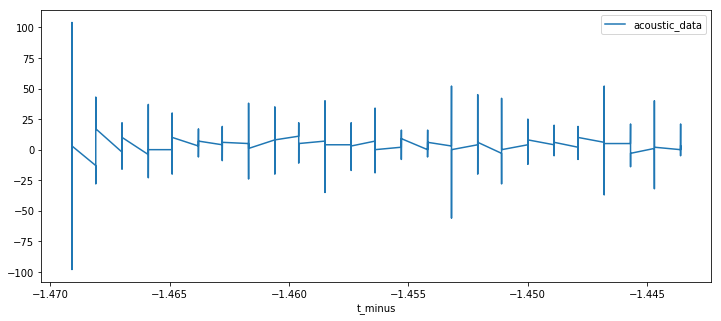

In [6]:
train_df.plot('t_minus', 'acoustic_data', figsize=(12,5))

Well it would have been nice if they had tagged a sequence number, but as far as data quality goes, this isn't too bad. We will need to add the segment markers ourselves. It looks like there are 25 distinct events, out of the 100,000 total rows we grabbed - so about 4,000 rows prior to each event.

In [7]:
train_df['t_minus'].diff().describe()

count    9.999800e+04
mean     2.550237e-07
std      1.640581e-05
min      1.100000e-09
25%      1.100000e-09
50%      1.100000e-09
75%      1.100000e-09
max      1.095495e-03
Name: t_minus, dtype: float64

So, typically there are about 1.1e-9 seconds between observations - but occasionally as many as 1.1e-3 seconds. Let's see what the bimodal distribution looks like so we can set a max allowable time limit between observations before saying that a new segment has begun.

In [8]:
train_df['t_diff'] = train_df['t_minus'].diff().fillna(train_df['t_minus'].diff().iloc[1])  # fill first nan with expected spacing value

In [9]:
train_df.head(3)

,acoustic_data,time_to_failure,t_minus,t_diff
0,12,1.4691,-1.4691,1.100000e-09
1,6,1.4691,-1.4691,1.100000e-09
2,8,1.4691,-1.4691,1.100000e-09


Text(0.5, 1.0, 'Sample spacing (seconds) within a single segment')

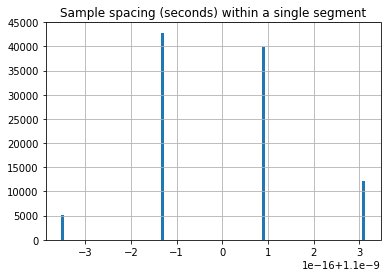

In [10]:
train_df['t_diff'][train_df['t_diff'] < 5e-9].hist(bins=100)
plt.title('Sample spacing (seconds) within a single segment')

Text(0.5, 1.0, 'Sample spacing (seconds) between segments')

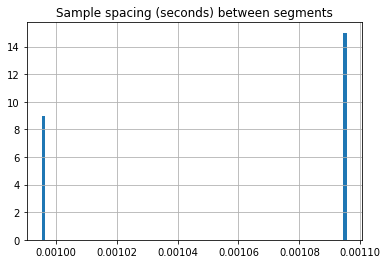

In [11]:
train_df['t_diff'][train_df['t_diff'] >= 5e-9].hist(bins=100)
plt.title('Sample spacing (seconds) between segments')

So, if `t_diff` < 5e-9, we are in the same segment. Otherwise, we are in a new segment.

In [12]:
train_df['segnum'] = (train_df['t_diff'] >= 5e-9).astype(int).fillna(0).abs().cumsum()

In [13]:
train_df.head(3)

,acoustic_data,time_to_failure,t_minus,t_diff,segnum
0,12,1.4691,-1.4691,1.100000e-09,0
1,6,1.4691,-1.4691,1.100000e-09,0
2,8,1.4691,-1.4691,1.100000e-09,0


In [14]:
train_df['segnum'].describe()

count    99999.000000
mean        11.712117
std          7.050438
min          0.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         24.000000
Name: segnum, dtype: float64

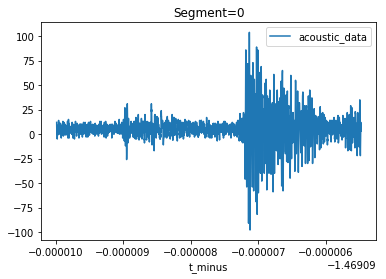

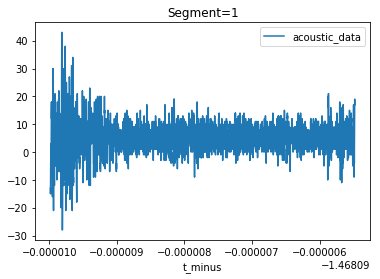

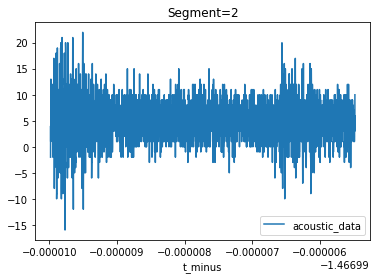

In [15]:
for segnum in range(3):
    train_df.groupby('segnum').get_group(segnum).plot('t_minus', 'acoustic_data')
    plt.title('Segment=' + str(segnum))

## About how many observations in each segment?

In [16]:
train_df.groupby('segnum').size().describe()

count      25.000000
mean     3999.960000
std       479.991708
min      1696.000000
25%      4096.000000
50%      4096.000000
75%      4096.000000
max      4096.000000
dtype: float64

So each one is supposed to be 4096 observations. That doesn't divide into 100,000 evenly, so let's drop our final segment for now, since we only have 1,696 observations in that one.

In [17]:
train_df = train_df[train_df['segnum'] != train_df['segnum'].max()]

In [18]:
train_df.groupby('segnum').size().describe()

count      24.000000
mean     4095.958333
std         0.204124
min      4095.000000
25%      4096.000000
50%      4096.000000
75%      4096.000000
max      4096.000000
dtype: float64

In [19]:
train_df[train_df['segnum'] == 0].shape

(4095, 5)

As far as I can tell, the first segment really does only have 4,095 data points. Let's just fix that...

In [20]:
last_line_of_first_segment = train_df[train_df['segnum'] == 0.0].sort_values('t_minus').iloc[-1]

In [21]:
train_df = train_df.append(last_line_of_first_segment, ignore_index=True).sort_values(['segnum', 't_minus'])

In [22]:
train_df.groupby('segnum').size().describe()

count      24.0
mean     4096.0
std         0.0
min      4096.0
25%      4096.0
50%      4096.0
75%      4096.0
max      4096.0
dtype: float64

Wundafurr. Now we can treat each segment the same.

Before we proceed, we want to turn our data into `float64`, since the range is so small. Once we normalize the values to [0,1], we will turn it back into `float32`, since that's what TensorFlow will be expecting.

In [23]:
train_df = train_df.astype(np.float64)

# TensorFlow Model

Now that we have segmented the data into distinct time-series datasets, we can train a neural network in TensorFlow to predict the number of seconds until the earthquake (the `t_minus` field) using the acoustic data. For our model, we will use an LSTM (Long Short-Term Memory) since it is commonly used to model sequences. Another good choice would be a GRU (Gated Recurrent Unit). These are both classes of Recurrent Neural Networks (RNNs), which are neural networks which pass hidden states and outputs to itself from one time step to the next. RNNs are a good choice whenever you have to create a model involving a sequence.

TensorFlow programs are defined in two stages:
- In the first stage, you define your **computation graph**. The graph contains **Placeholders** for your inputs and all processing steps (i.e. the steps of the neural network). Some nodes in the graph contain trainable weights called **Variables** which TensorFlow will update for you - any trainable weight in a neural network is stored in a Variable.
- In the second stage, you feed labeled training data into the computation graph. (At test/prediction time, you just omit the labels.) The network feeds the features through the computation graph and gets some output, which is dependent on the current setting of the Variables. TensorFlow compares the output to the label. The error signal ($y - \hat{y}$) is then propagated backward through the network and is used to update the weights.

In the context of our problem, we want to use a neural network to solve a regression problem, since the `t_minus` field, our target time until the next earthquake, is real-valued. 

![LSTM](/persistent-code/lstm.png)

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [24]:
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.nn.rnn_cell import LSTMCell
from tensorflow.nn import static_rnn
from tensorflow.initializers import truncated_normal
from tensorflow.layers import Dense
import numpy as np
import time
import pickle

In [25]:
tf.reset_default_graph()
if 'sess' in dir():
    sess.close()
    del sess
sess = tf.InteractiveSession()

## Define computation graph

In [26]:
BATCH_SIZE     = 8
TIMESTEPS      = 128
#N_FEATS        = 1
LSTM_CELL_SIZE = 128

In [27]:
# Placeholders for inputs and outputs
tf_X = tf.placeholder(tf.float64, shape=(BATCH_SIZE, TIMESTEPS), name='input_placeholder')
tf_y = tf.placeholder(tf.float64, shape=(BATCH_SIZE, TIMESTEPS), name='output_placeholder')

In [28]:
# Create LSTM layer
rnn_input = tf.reshape(tf_X, (BATCH_SIZE, TIMESTEPS, 1))
lstm_initializer = truncated_normal(stddev=0.05, seed=1234, dtype=tf.float64)

lstm_cell = LSTMCell(num_units=LSTM_CELL_SIZE,
                     initializer=lstm_initializer,
                     activation=tf.nn.leaky_relu,
                     reuse=False,
                     dtype=tf.float64,
                     name='lstm_cell')

rnn_output, states = static_rnn(cell=lstm_cell,
                                inputs=[rnn_input[:,i,:1] for i in range(TIMESTEPS)],
                                dtype=tf.float64)

In [29]:
# Reshape RNN output
final_rnn_output = tf.reshape(rnn_output, (BATCH_SIZE, TIMESTEPS * LSTM_CELL_SIZE))

In [30]:
# Pass through a Dense layer
dense = Dense(units=TIMESTEPS, activation=tf.nn.leaky_relu, name='dense_layer', dtype=tf.float64)(final_rnn_output)

In [31]:
# Reshape to same shape as `outputs'
results = tf.reshape(dense, (BATCH_SIZE, TIMESTEPS * 1))

In [32]:
# Calculate loss as sum-of-squared errors
loss = tf.reduce_sum(tf.square(tf_y - results), name='loss_sse')

At this point, our network can take in 8 data segments at a time (`BATCH_SIZE`), each segment an array of length 1024 (`TIMESTEPS`). This means we will have to batch up our data and loop through every 8 segments to feed dataframes to the network in batches of size 8x1024. But before we do, we need to tell TensorFlow that the objective is to minimize the `loss` variable that we defined above, which we calculated as the sum of squared differences between the labels (`y`) and the estimates (`results`).

In [33]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize(loss)

The two lines above tell TensorFlow what to minimize (`loss`), and how to minimize it (using the `RMSProp` algorithm).

## Feeding data into the network

First, we need to create a function that will loop over our DataFrame and return the data of the expected size: 8x1024.

In [34]:
def data_loop_generator(df, batch_size, timesteps, segment_length=4096, num_steps=100):
    n_segments = df['segnum'].nunique()
    step = 0
    
    # Perform input and output value scaling to [0, 1]
    Xlim = [min(df['acoustic_data']), max(df['acoustic_data'])]
    Ylim = [min(df['t_minus']), max(df['t_minus'])]
    X_inverted = abs(Xlim[1]) < 1e-12
    Y_inverted = abs(Ylim[1]) < 1e-12
    
    if X_inverted:
        print('Inverted X to prevent a divide-by-zero')
        df['acoustic_data'] = -df['acoustic_data']
        Xlim = [min(df['acoustic_data']), max(df['acoustic_data'])]
    
    if Y_inverted:
        print('Inverted Y to prevent a divide-by-zero')
        df['t_minus'] = -df['t_minus']
        Ylim = [min(df['t_minus']), max(df['t_minus'])]
    
    df['acoustic_data'] = (df['acoustic_data'] - Xlim[0]) / Xlim[1]
    df['t_minus'] = (df['t_minus'] - Ylim[0]) / Ylim[1]
    
    with open('ranges.pickle', 'wb') as pkl:
        pickle.dump([Xlim, Ylim, X_inverted, Y_inverted], pkl)
    
    while True:
        # Take batch_size randomly-selected segments, with replacement
        segs = np.random.permutation(n_segments)[:batch_size]
        data = df[df['segnum'].isin(segs)][['acoustic_data', 't_minus']].values
        X = data[:,0].reshape((batch_size, segment_length))
        y = data[:,1].reshape((batch_size, segment_length))
        
        for idx in range(int(segment_length / timesteps)):
            start = idx * timesteps
            end = start + timesteps
            yield X[:, start:end], y[:, start:end]
            step += 1
            if step > num_steps:
                raise Exception('finished')

Now, we can loop over X, y in the data loop generator and feed data into our network:

In [35]:
NUM_STEPS = 5000
PRINT_EVERY = 250

In [2]:
def timestamp():
    return time.strftime('%Y-%m-%d %H:%M:%S')

In [37]:
init = tf.global_variables_initializer()
dlg = data_loop_generator(train_df, BATCH_SIZE, TIMESTEPS, num_steps=NUM_STEPS)

init.run()
history = []
tracker = {}
for step in range(NUM_STEPS):
    X, y = next(dlg)
    mse, _ = sess.run([loss, train_op], feed_dict={tf_X: X, tf_y: y})
    history.append(mse)
    if step % PRINT_EVERY == 0 or step == NUM_STEPS-1:
        print('[%s] Step=%d MSE=%f' % (timestamp(), step, mse))
        
        # also track inputs, outputs, and estimate for this iteration
        estimate = sess.run(results, feed_dict={tf_X: X, tf_y: y})
        tracker[step] = {'X': X, 'y': y, 'estimate': estimate}

[2019-01-16 23:33:54] Step=0 MSE=1.095435
[2019-01-16 23:34:13] Step=250 MSE=0.027786
[2019-01-16 23:34:34] Step=500 MSE=0.024714
[2019-01-16 23:34:53] Step=750 MSE=0.017794
[2019-01-16 23:35:13] Step=1000 MSE=0.018922
[2019-01-16 23:35:33] Step=1250 MSE=0.001011
[2019-01-16 23:35:53] Step=1500 MSE=0.005321
[2019-01-16 23:36:14] Step=1750 MSE=0.003956
[2019-01-16 23:36:33] Step=2000 MSE=0.001044
[2019-01-16 23:36:54] Step=2250 MSE=0.001899
[2019-01-16 23:37:14] Step=2500 MSE=0.002997


KeyboardInterrupt: 

Text(0, 0.5, 'MSE')

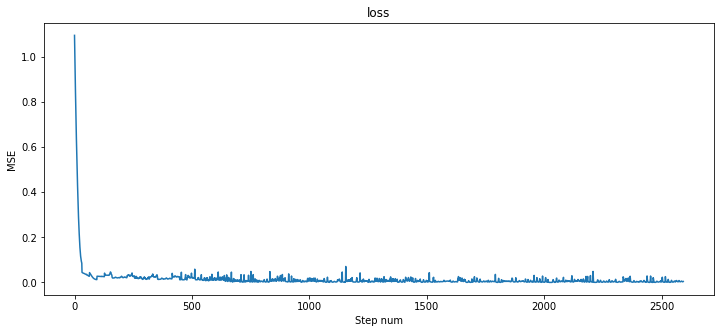

In [38]:
plt.figure(figsize=(12,5))
plt.plot(history)
plt.title('loss')
plt.xlabel('Step num')
plt.ylabel('MSE')

MSE here has a special interpretation, since we scaled our outputs: it is the MSE *as a percentage of the output range*. Since the original output range was very small, that means that our model has done a pretty good job learning the relationship between the inputs and outputs, even on this relatively small (truncated) dataset.

Once we start to predict outputs, we will need to reverse the scaling operation (multiply by maximum value and add the minimum value) to take us back to the original output space. Note that as always, these values are set according to the training data. If we encounter real-world data outside this range, our model is unlikely to perform as well.

In [42]:
key = max(tracker.keys())
print('Status after %d steps: ' % key)
tracker[key]

Status after 2500 steps: 


{'X': array([[0.96153846, 0.92307692, 0.99038462, ..., 0.99038462, 0.91346154,
         0.93269231],
        [0.93269231, 0.99038462, 0.96153846, ..., 0.97115385, 1.        ,
         1.00961538],
        [0.99038462, 0.97115385, 0.96153846, ..., 0.89423077, 0.93269231,
         0.96153846],
        ...,
        [0.96153846, 0.98076923, 1.01923077, ..., 1.        , 0.98076923,
         0.99038462],
        [1.08653846, 1.15384615, 1.19230769, ..., 1.10576923, 1.06730769,
         1.05769231],
        [0.98076923, 1.        , 1.00961538, ..., 0.98076923, 1.02884615,
         1.        ]]),
 'estimate': array([[ 0.0009975 ,  0.00027915,  0.00303189, ..., -0.00026269,
          0.00182343,  0.00027052],
        [-0.00176849, -0.00211448, -0.00165746, ..., -0.00292989,
         -0.00192838, -0.00225342],
        [-0.00400458, -0.00397558, -0.00380787, ..., -0.00469455,
         -0.00408778, -0.00406433],
        ...,
        [-0.00899737, -0.00933975, -0.00871679, ..., -0.00980477,
       

## Train on entire dataset

In [5]:
df = pd.read_csv('/workspace/persistent-data/earthquake/train/train.csv', header=0,
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, engine='c')

In [6]:
df['t_minus'] = -df['time_to_failure']

In [7]:
df['t_diff'] = df['t_minus'].diff().fillna(1.1e-9)  # fill first nan with expected spacing value

In [8]:
df.head(3)

,acoustic_data,time_to_failure,t_minus,t_diff
0,12,1.4691,-1.4691,1.100000e-09
1,6,1.4691,-1.4691,1.100000e-09
2,8,1.4691,-1.4691,1.100000e-09


In [9]:
df['segnum'] = (df['t_diff'] >= 4e-9).astype(int).fillna(0).abs().cumsum()

In [10]:
df = df.drop('time_to_failure', axis=1)

In [11]:
df.head(3)

,acoustic_data,t_minus,t_diff,segnum
0,12,-1.4691,1.100000e-09,0
1,6,-1.4691,1.100000e-09,0
2,8,-1.4691,1.100000e-09,0


### Let's explore irregular sequence shapes

In [11]:
df.groupby('segnum').size().describe()

count    153584.000000
mean       4096.425930
std          41.804778
min        4095.000000
25%        4096.000000
50%        4096.000000
75%        4096.000000
max        8192.000000
dtype: float64

In [12]:
segsize = df.groupby('segnum').size()

In [16]:
segsize[segsize != 4096].shape

(136,)

In [18]:
segsize[segsize != 4096].value_counts()

4095    120
8192     16
dtype: int64

In [26]:
pd.Series(segsize[segsize == 4095].index).diff().head(10)

0       NaN
1    1280.0
2    1279.0
3    1280.0
4    1280.0
5    1280.0
6    1280.0
7    1280.0
8    1280.0
9    1280.0
Name: segnum, dtype: float64

So there appears to be a regular pattern to the sequences having only length=4,095 - they occur (roughly) every 1280 sequences.

In [35]:
pd.Series(segsize[segsize == 8192].index).diff()

0         NaN
1     10846.0
2     13327.0
3      8323.0
4     11930.0
5      7570.0
6      6634.0
7     15138.0
8      7430.0
9      9057.0
10    10739.0
11    10361.0
12     8297.0
13     8050.0
14    13864.0
15     8890.0
Name: segnum, dtype: float64

No such regular pattern to the 8192's. Let's see what is the actual spacing in the 8192's.

In [41]:
ei_df = df[df['segnum'].isin(segsize[segsize == 8192].index)]

In [45]:
ei_df['t_diff'].describe()

count    1.310720e+05
mean    -1.309849e-03
std      1.219251e-01
min     -1.610690e+01
25%      1.099580e-09
50%      1.100000e-09
75%      1.100030e-09
max      1.095496e-03
Name: t_diff, dtype: float64

min values less than 0? interesting...

In [44]:
(ei_df['t_diff'] < 0).sum()

16

Ah, there it is - these sequences weren't flagged by the segmenter because they begin *before* the previous sequence ends. Not in row-order, but in time-order. Sorting could possibly lead to mixing some of their values in with the values of other sequences, so we don't want to do that.

## Write the data to TFRecords

In [3]:
import os.path as osp

In [22]:
def write_seg(sdf, segnum, outdir='/workspace/persistent-data/earthquake/segments'):
    if len(sdf) == 4095:
        # Duplicate last entry
        sdf = sdf.append(sdf.iloc[-1], ignore_index=True)
    
    if len(sdf) == 8192:
        # Split segments
        write_seg(sdf.iloc[:4096], str(segnum) + '_1')
        write_seg(sdf.iloc[4096:], str(segnum) + '_2')
    else:
        if len(sdf) != 4096:
            print('[%s] ERROR: Segment ' + str(segnum) + ' has irregular length: %d' % (timestamp(), segnum))
            return
        if (sdf['t_minus'].iloc[1:].diff() < 0).sum() > 0:
            print('[%s] ERROR: Segment ' + str(segnum) + ' has %d decreasing timesteps' % (timestamp(),
                                                                                           sdf['t_minus'].iloc[1:].diff() < 0).sum())
            return
        outpath = osp.join(outdir, str(segnum) + '.pickle')
        sdf[['t_minus', 'acoustic_data']].reset_index(drop=True).to_pickle(outpath)

In [ ]:
i = 0
print('[%s] started writing %d segments' % (timestamp(), df['segnum'].nunique()))
for segnum, sdf in df.groupby('segnum'):
    write_seg(sdf, segnum)
    i += 1
    if i % 1000 == 0:
        print('[%s] Wrote %d segments' % (timestamp(), i))

[2019-01-18 05:33:07] started writing 153584 segments
[2019-01-18 05:34:02] Wrote 1000 segments
[2019-01-18 05:34:05] Wrote 2000 segments
[2019-01-18 05:34:08] Wrote 3000 segments
[2019-01-18 05:34:10] Wrote 4000 segments
[2019-01-18 05:34:13] Wrote 5000 segments
[2019-01-18 05:34:15] Wrote 6000 segments
[2019-01-18 05:34:17] Wrote 7000 segments
[2019-01-18 05:34:20] Wrote 8000 segments
[2019-01-18 05:34:22] Wrote 9000 segments
[2019-01-18 05:34:24] Wrote 10000 segments
[2019-01-18 05:34:27] Wrote 11000 segments
[2019-01-18 05:34:29] Wrote 12000 segments
[2019-01-18 05:34:32] Wrote 13000 segments
[2019-01-18 05:34:34] Wrote 14000 segments
[2019-01-18 05:34:36] Wrote 15000 segments
[2019-01-18 05:34:39] Wrote 16000 segments
[2019-01-18 05:34:41] Wrote 17000 segments
[2019-01-18 05:34:44] Wrote 18000 segments
[2019-01-18 05:34:46] Wrote 19000 segments
[2019-01-18 05:34:48] Wrote 20000 segments


Anyway, the above completed but failed on the segments where length=4095. Let's find out why.

[EDIT]: Ah, a broken if-statement... whoops.

In [14]:
df = df[df['segnum'].isin(segsize[segsize == 4095].index)]

In [15]:
df['segnum'].nunique() == 120

True

In [23]:
i = 0
print('[%s] started writing %d segments' % (timestamp(), df['segnum'].nunique()))
for segnum, sdf in df.groupby('segnum'):
    print('writing segment %d (len=%d)' % (segnum, len(sdf)))
    write_seg(sdf, segnum)
    i += 1
    if i % 10 == 0:
        print('[%s] Wrote %d segments' % (timestamp(), i))

[2019-01-18 06:20:32] started writing 120 segments
writing segment 0 (len=4095)
writing segment 1280 (len=4095)
writing segment 2559 (len=4095)
writing segment 3839 (len=4095)
writing segment 5119 (len=4095)
writing segment 6399 (len=4095)
writing segment 7679 (len=4095)
writing segment 8959 (len=4095)
writing segment 10239 (len=4095)
writing segment 11519 (len=4095)
[2019-01-18 06:20:32] Wrote 10 segments
writing segment 12798 (len=4095)
writing segment 14078 (len=4095)
writing segment 15358 (len=4095)
writing segment 16638 (len=4095)
writing segment 17918 (len=4095)
writing segment 19198 (len=4095)
writing segment 20478 (len=4095)
writing segment 21758 (len=4095)
writing segment 23038 (len=4095)
writing segment 24318 (len=4095)
[2019-01-18 06:20:32] Wrote 20 segments
writing segment 25597 (len=4095)
writing segment 26877 (len=4095)
writing segment 28157 (len=4095)
writing segment 29437 (len=4095)
writing segment 30717 (len=4095)
writing segment 31997 (len=4095)
writing segment 33277 

# Under the hood

### Tensors

The computational graph in TensorFlow operates on **tensors**, which are multidimensional arrays. You already know what a multidimensional array is:
* A 1-dimensional array is a list 
> `[1, 2, 3, ...]`
* A 2-dimensional array is a list of lists
> `[[0, 1], [1, 2], [7, 7], [...]]`
* A 3-dimensional array is a list of 2-dimensional arrays
> `[[[0, 1, 1], [1, 2, 2]], [[0, 1, 2], [2, 3, 3]], [[...]]]`
* And so on

A tensor has the added condition that it must be **(hyper)rectangular**, i.e. all sub-arrays are of uniform size. For instance:
* A 1-dimensional tensor with shape `(3,)` is a list of 3 elements
> `[1, 2, 3]`
* A 2-dimensional tensor with shape `(2, 3)` is a 2-element list of 3-element lists
> `[[1, 2, 3], [3, 2, 1]]]`

Something irregularly shaped like [[1, 2], [1]] cannot be a tensor, because the subarrays do not have uniform length. When we are modeling sequences, this is a very important limitation, because what if sequences have unequal length? In practice, you can *mask* values of input tensors beyond the length of the original sequence with 0's, and pad them out to the required length - typically, this is the length of the longest input sequence. So, you just make the tensor large enough to fit the longest sequence, and pad the shorter ones with 0's. That way, TensorFlow won't penalize the model for incorrect estimates beyond the length of the original input sequence.

### Ops

An **Op** is a function that lives on the computational graph which takes an input tensor and returns an output tensor. Typically, an **op** will do something like a matrix-multiply operation in the case of two input 2-D tensors, or a dot-product, or adding a constant, or something. In the code above, the `tf.reshape` calls result in a `Reshape` **Op** being added to the graph, and those ops take in a single tensor and return a single tensor with a different shape. The more complex functions, like `LSTMCell` and `Dense`, often result in many ops being added to the graph, but you only have to worry about the shape of the input and output tensors.

Keep in mind that in TensorFlow, **everything** is either a tensor or an op!

# Visualize the ops and tensors on your graph with TensorBoard

![tensorboard-graph](/persistent-code/graph.png)

# Industrial strength TensorFlow

In the Real World (R) there is a lot of scaffolding around TensorFlow which eases many common use cases. For now, we will focus on the two APIs which tackle the biggest problems, which are the two mentioned above: Creating your computational graph, and feeding data to your model.

### Easier model building with `tf.Estimator`

To assist with building computational graphs, and to standardize the model import/export/checkpointing process, the TensorFlow team created the `tf.Estimator` API, which allows you to focus on developing the internals of your model without having to worry about acquiring a TensorFlow context, managing the state of the graph, etc. etc. At least, that was the idea. In reality, what it *actually* does is separate the complexity of managing TensorFlow's input/output semantics from the meat of your model. This does turn out to be really helpful, and you will benefit from using this API.

### Faster data pipelines with `tf.data`

![tfdata](/persistent-code/tf-data.png)

`tf.data` contains classes and functions which offload the data input process to an auxiliary graph which runs concurrently with your main model graph, and handles pipelining the preprocessing and batching up of your data. In practice, this makes your model train much, much faster, especially when you have tons of data-hungry GPUs.

https://cs230-stanford.github.io/tensorflow-input-data.html

# Keep tabs on your model with TensorBoard

![tensorboard](/persistent-code/tensorboard.png)